# Dec 10th, 2021 (tSNR: identify bad areas)

**Motivation**: temporal SNR for BOLD is used to identify brain areas with poor signal <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def _load(mice, key, which: str = 'both', raw_bold: bool = False, space='individual'):
    if which == 'both':
        which = ['ca2', 'bold']
    else:
        which = [which]
    sub, ses, _ = mice.looper[key]
    
    if 'ca2' in which:
        m2d = mice.mask2d[mice.get_key(sub, ses)]
        m2d = m2d.load_ants().numpy().astype(bool)
        x2d = mice.ca_preproc[key][:]
        if x2d is None:
            out2d = None
        else:
            mu2d = x2d.mean(-1)
            sd2d = x2d.std(-1)
            snr2d = mu2d / sd2d
            out2d = {
                'm': m2d,
                'x': x2d,
                'gs': x2d[m2d].mean(0),
                'mu_abs': np.abs(x2d).mean(-1),
                'mu': mu2d,
                'sd': sd2d,
                'snr': snr2d,
                'snr_avg': bn.nanmean(snr2d[m2d]),
            }
    else:
        out2d = None

    if 'bold' in which:
        if raw_bold:
            file = 'Symmetric_N162_0.20.nii.gz'
            file = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', file)
            m3d = ants.image_read(file).numpy().astype(bool)
            try:
                file = next(
                    f for f in os.listdir(mice.cfg.npy_dir) if
                    all(e in f for e in [key, f"space-{space}_desc-raw"])
                )
                file = pjoin(mice.cfg.npy_dir, file)
                x3d = np.load(file)
            except StopIteration:
                x3d = None
        else:
            m3d = mice.mask3d[mice.get_key(sub, ses)]
            m3d = m3d.load_ants().numpy().astype(bool)
            x3d = mice.bold_preproc[key][:]
        if x3d is None:
            out3d = None
        else:
            mu3d = x3d.mean(-1)
            sd3d = x3d.std(-1)
            snr3d = mu3d / sd3d
            out3d = {
                'm': m3d,
                'x': x3d,
                'gs': x3d[m3d].mean(0),
                'mu_abs': np.abs(x3d).mean(-1),
                'mu': mu3d,
                'sd': sd3d,
                'snr': snr3d,
                'snr_avg': bn.nanmean(snr3d[m3d]),
            }
    else:
        out3d = None
        
    return out2d, out3d


def plot_1(gs2d, gs3d, key, nb_stds=2, ab=None, chunk_size=300, alpha=0.2):

    num = int(600 / chunk_size)
    nrows = 2 * (num + 1)

    fig, axes = create_figure(nrows, 1, (13.5, 2 * nrows),
                              gridspec_kw={'height_ratios': [1.5] * 2 + [1] * num * 2})
    axes[0].plot(gs2d, color='g')
    axes[1].plot(gs3d, color='r')
    
    sd = bn.nanstd(gs2d)
    axes[0].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[0].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[0].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    sd = bn.nanstd(gs3d)
    axes[1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[1].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[1].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    
    if ab is not None:
        a, b = ab
        axes[0].axvspan(a * 10, b * 10, color='magenta', alpha=0.3)
        axes[1].axvspan(a, b, color='magenta', alpha=0.3)

    for i in range(1, num + 1):
        start = (i - 1) * chunk_size
        end = i * chunk_size
        intvl = range(start * 10, min(end * 10, len(gs2d)))
        axes[2 * i].plot(intvl, gs2d[intvl], color='dimgrey')

        intvl = range(start, min(end, len(gs3d)))
        axes[2 * i + 1].plot(intvl, gs3d[intvl], color='k')
        
        sd = bn.nanstd(gs2d[intvl])
        axes[2 * i].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        sd = bn.nanstd(gs3d[intvl])
        axes[2 * i + 1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        

    for i in range(2):
        axes[2 * i].axvspan(0, 50 * 10, color='dimgrey', alpha=0.3)
        axes[2 * i + 1].axvspan(0, 50, color='dimgrey', alpha=0.3)

    fig.suptitle(f"plot #1, {key}", fontsize=14, y=1.02)
    plt.show()
    
    return fig, axes


def plot_2(out2d, key, threshold=0.05):
    xlist = [out2d['mu_abs'], out2d['mu'], out2d['sd'], out2d['snr'], out2d['m']]
    mu_abs, mu, sd, snr, m = filter_boundaries(xlist, out2d['m'])
    snr = np.abs(snr)
    
    fig1, axes = create_figure(1, 4, (13, 3.2), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})

    im = axes[0].imshow(mu_abs, cmap='Spectral')
    plt.colorbar(im, ax = axes[0], shrink=0.7)

    im = axes[1].imshow(mu, cmap='Spectral')
    plt.colorbar(im, ax = axes[1], shrink=0.7)

    im = axes[2].imshow(sd, cmap='Spectral')
    plt.colorbar(im, ax = axes[2], shrink=0.7)

    im = axes[3].imshow(snr, cmap='Spectral')
    plt.colorbar(im, ax = axes[3])

    axes[0].set_title(r'$\mu$ (abs)')
    axes[1].set_title(r'$\mu$')
    axes[2].set_title(r'$\sigma$')
    axes[3].set_title(r'tSNR $ = abs(\mu / \sigma)$')
    fig1.suptitle(f"plot #2, {key}", fontsize=14, y=1.02)
    remove_ticks(axes)
    plt.show()
    
    fig2, axes = create_figure(1, 2, (12, 2.7))

    vals = snr[np.logical_and(m, np.isfinite(snr))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    axes[1].imshow(snr > q)
    remove_ticks(axes[1])
    plt.show()
    
    gs_good = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) > q)].mean(0)
    gs_bad = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) <= q)].mean(0)
    
    fig3, ax = create_figure(1, 1, (13, 4), sharex='all', sharey='all')
    ax.plot(gs_bad, color='r', lw=0.7, label='gs bad')
    ax.plot(gs_good, color='k', lw=0.9, label='gs good')
    ax.legend(fontsize='large')
    ax.grid()
    plt.show()
    
    return fig1, fig2, fig3


def plot_3(out3d, key, display: bool = True, threshold=0.05, slice_ids=None):
    slice_ids = slice_ids if slice_ids else [10, 20, 30, 40]
    snr = np.abs(out3d['snr'])
    
    fig1, axes = create_figure(
        3, len(slice_ids) + 1, figsize=(13, 6.),
        gridspec_kw={'width_ratios': [1] * len(slice_ids) + [1.6]})

    for i in range(3):
        for j, s in enumerate(slice_ids):
            x2plt = np.take(snr, s, axis=i)
            if i == 2:
                x2plt = x2plt.T
            im = axes[i, j].imshow(x2plt, cmap='Spectral')
            plt.colorbar(im, ax=axes[i, j], shrink=0.7)
        x2plt = bn.nanmean(snr, axis=i)
        x2plt = filter_boundaries(x2plt, out3d['m'].mean(i).astype(bool))
        if i == 2:
            x2plt = x2plt.T
        im = axes[i, -1].imshow(x2plt, cmap='Spectral')
        plt.colorbar(im, ax=axes[i, -1], shrink=0.7)
        fig1.suptitle(f"plot #3, {key}", fontsize=14, y=1.01)

    remove_ticks(axes)
    plt.show()

    fig2, axes = create_figure(1, 4, (13, 2.7))

    vals = out3d['snr'][np.logical_and(out3d['m'], np.isfinite(out3d['snr']))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    above = out3d['snr'] > q
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    for i in range(1, 4):
        x2plt = above.mean(i - 1)
        if i == 3:
            x2plt = x2plt.T
        axes[i].imshow(x2plt)
        remove_ticks(axes[i])
    plt.show()

    return fig1, fig2


def plot_4(mice, sub, ses, brief: bool = True, display: bool = True, threshold=0.05):
    data = []
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        out2d, _ = _load(mice, key, 'ca2')

        snr, m = filter_boundaries([out2d['snr'], out2d['m']], out2d['m'])
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data.append((snr, m, vals, q))

    if brief:
        nrows = 2
        fig, axes = create_figure(
            nrows=nrows,
            ncols=len(data),
            figsize=(13, 2 * nrows),
        )
        for i in range(len(data)):
            snr, _, _, q = data[i]
            axes[0, i].imshow(snr, cmap='Spectral')
            axes[1, i].imshow(snr > q)
            axes[0, i].set_title(f"run # {i+1}", y=1.03)
        remove_ticks(axes)
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=14, y=1.03)
    
    else:
        ncols = 6
        nrows = int(np.ceil(len(data) / 2))
        fig, axes = create_figure(
            nrows=nrows,
            ncols=ncols,
            figsize=(13, 2. * nrows),
            gridspec_kw={'width_ratios': [1.4, 1, 1.2] * 2},
        )
        for i in range(nrows):
            for j in range(2):
                idx = 2 * i + j
                try:
                    snr, m, vals, q = data[idx]
                except IndexError:
                    continue

                im = axes[i, 3 * j].imshow(snr, cmap='Spectral')
                plt.colorbar(im, ax=axes[i, 3 * j], shrink=0.8)
                axes[i, 3 * j + 1].imshow(snr > q)
                sns.histplot(vals, ax=axes[i, 3 * j + 2])
                axes[i, 3 * j + 2].axvline(q, color='r', ls='--', lw=1, label=f"q = {q:0.3f}")
                axes[i, 3 * j + 2].legend()
                axes[i, 3 * j + 2].grid()
                remove_ticks(axes[i, :2])
                remove_ticks(axes[i, 3:5])
        remove_ticks(axes.flat[-1])
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=17, y=1.03)
        
    if display:
        plt.show()
    else:
        plt.close()
        
    return fig, sup, axes


def plot_5(
    mice: Mice,
    sub: int,
    ses: int,
    threshold=0.5,
    space: str = 'N162',
    display: bool = True,
    raw_bold: bool = True,):
    
    data = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        _, out3d = _load(mice, key, 'bold', raw_bold=raw_bold, space=space)
        if out3d is None:
            continue

        snr, m = out3d['snr'], out3d['m']
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data[run] = (snr, m, vals, q)

    nrows = len(data)
    fig, axes = create_figure(nrows, 4, (13, 2.2 * nrows), gridspec_kw={'width_ratios': [1.8, 1, 1, 1]})
    for i in range(nrows):
        snr, m, vals, q = data[i + 1]
        sns.histplot(vals, ax=axes[i, 0])
        axes[i, 0].axvline(q, color='r', ls='--', lw=0.9, label=f"q = {q:0.3f}")
        axes[i, 0].set_ylabel(f"run # {i + 1}\n", fontsize=13)
        axes[i, 0].legend()
        
        above = snr > q
        for j in range(1, 4):
            x2plt = above.mean(j - 1)
            if j == 3:
                x2plt = x2plt.T
            axes[i, j].imshow(x2plt)
            remove_ticks(axes[i, j])
    sup = f"{mice.get_key(sub, ses)} (bold) / temporal SNR = "
    sup += r'$\mu / \sigma$'
    sup = fig.suptitle(sup, fontsize=17, y=1.03)
    
    if display:
        plt.show()
    else:
        plt.close()
    
    return data, (fig, sup, axes)

In [4]:
mice = Mice((192, 4))

In [5]:
%%time

threshold = 0.5

figs, sups  = [], []
snr_all, q_vals = [], []

for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        try:
            data, (fig, sup, _) = plot_5(
                mice=mice,
                sub=sub,
                ses=ses,
                threshold=threshold,
                display=False,
                raw_bold=True,
                space='N162',
            )
            figs.append(fig)
            sups.append(sup)
            for i in data:
                q_vals.append(data[i][-1])
                snr_all.append(np.expand_dims(data[i][0], 0))
        except (TypeError, KeyError):
            continue
snr_all = np.concatenate(snr_all)
q_vals = np.array(q_vals)

CPU times: user 6min 9s, sys: 9min 24s, total: 15min 33s
Wall time: 31min 12s


In [160]:
save_fig(
    fig=figs,
    sup=sups,
    save_file=pjoin(tmp_dir, f'tsnr_bold_perc{100 * threshold:0.0f}.pdf'),
    display=False,
    multi=True,
)

In [6]:
snr_all[~np.isfinite(snr_all)] = np.nan
snr_avg = bn.nanmean(snr_all, 0)
snr_avg.shape

(60, 46, 81)

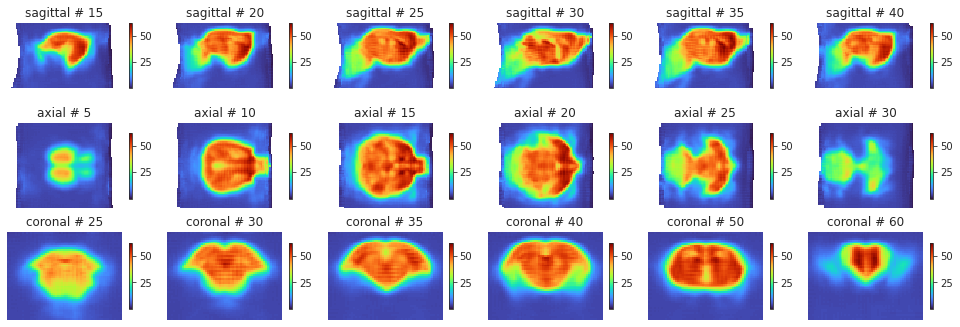

In [10]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

cmap = 'turbo'

vmin = np.nanmin(snr_avg)
vmax = np.nanmax(snr_avg[np.isfinite(snr_avg)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr_avg.take(s, 0), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr_avg.take(s, 1), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr_avg.take(s, 2).T, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
remove_ticks(axes)
plt.show()

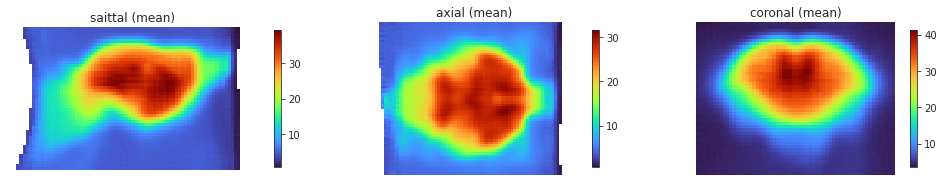

In [11]:
fig, axes = create_figure(1, 3, (13.5, 2.6))

x2plt = snr_avg.copy()
x2plt[~np.isfinite(x2plt)] = np.nan

for i, lbl in enumerate(['saittal', 'axial', 'coronal']):
    axes[i].set_title(f"{lbl} (mean)")
    _x2plt = bn.nanmean(x2plt, i)
    if i == 2:
        _x2plt = _x2plt.T
    im = axes[i].imshow(_x2plt, cmap=cmap)
    plt.colorbar(im, ax=axes[i], shrink=0.9)
    
remove_ticks(axes)
plt.show()

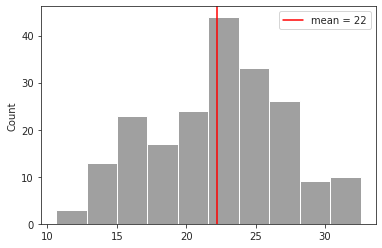

In [12]:
sns.histplot(q_vals, color='grey')
plt.axvline(np.mean(q_vals), color='r', label=f"mean = {np.mean(q_vals):0.0f}")
plt.legend()
plt.show()

In [13]:
(q_vals < 15).sum()

16

In [14]:
np.where(q_vals < 15)[0]

array([  3,  67,  94,  95, 126, 129, 130, 156, 157, 158, 159, 162, 163,
       165, 166, 187])

In [15]:
len(q_vals), len(snr_all)

(202, 202)

In [16]:
in_house = 'Symmetric_N162_0.20.nii.gz'
in_house = pjoin(mice.cfg.base_dir, 'Yale', 'atlases_templates', in_house)
in_house = ants.image_read(in_house)
in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [17]:
from register.register import reset_ants_img
snr_img = reset_ants_img(snr_avg, spacing=in_house.spacing, origin=in_house.origin, dtype='float', use_um=False)
snr_img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [18]:
ants.image_write(snr_img, pjoin(tmp_dir, 'tSNR_avg.nii.gz'))

In [19]:
snr_filt_avg = snr_all.copy()
snr_filt_avg = bn.nanmean(snr_filt_avg[q_vals > 15], 0)

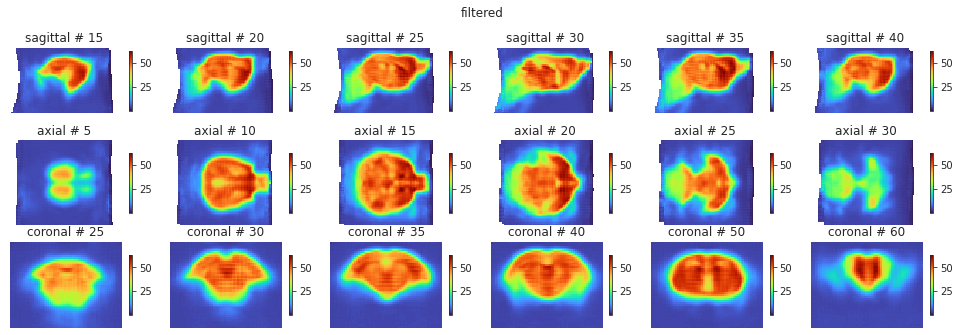

In [20]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

vmin = np.nanmin(snr_filt_avg)
vmax = np.nanmax(snr_filt_avg[np.isfinite(snr_filt_avg)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 0), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 1), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 2).T, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
fig.suptitle('filtered')
remove_ticks(axes)
plt.show()

In [130]:
snr_img = reset_ants_img(
    snr_filt_avg,
    spacing=in_house.spacing,
    origin=in_house.origin,
    dtype='float',
    use_um=False,
)
ants.image_write(snr_img, pjoin(tmp_dir, 'tSNR_filt_avg.nii.gz'))

In [174]:
_ = save_obj(
    obj=q_vals,
    file_name='q_vals',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'q_vals.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [22]:
_ = save_obj(
    obj=snr_all,
    file_name='snr_all',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'snr_all.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [23]:
_ = save_obj(
    obj=snr_filt_avg,
    file_name='snr_filt_avg',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'snr_filt_avg.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

## Load test

In [3]:
q_vals = np.load(pjoin(tmp_dir, 'q_vals.npy'))
snr_all = np.load(pjoin(tmp_dir, 'snr_all.npy'))

In [4]:
snr_filt_avg = snr_all.copy()
snr_filt_avg = bn.nanmean(snr_filt_avg[q_vals > 15], 0)

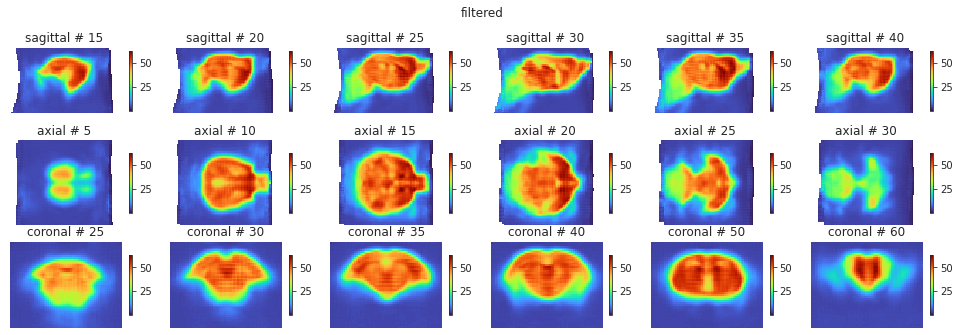

In [5]:
fig, axes = create_figure(3, 6, (13.5, 4.7))

cmap = 'turbo'

vmin = np.nanmin(snr_filt_avg)
vmax = np.nanmax(snr_filt_avg[np.isfinite(snr_filt_avg)])

for j, s in enumerate([15, 20, 25, 30, 35, 40]):
    ax = axes[0, j]
    ax.set_title(f"sagittal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 0), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)

for j, s in enumerate([5, 10, 15, 20, 25, 30]):
    ax = axes[1, j]
    ax.set_title(f"axial # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 1), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
    
for j, s in enumerate([25, 30, 35, 40, 50, 60]):
    ax = axes[2, j]
    ax.set_title(f"coronal # {s}")
    im = ax.imshow(snr_filt_avg.take(s, 2).T, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, shrink=0.7)
fig.suptitle('filtered')
remove_ticks(axes)
plt.show()

## tSNR for brain regions

In [6]:
mice = Mice((192, 4), load_allen=True)

### Stuff from Allen 2 in house

In [7]:
from register.register import Register, reset_ants_img

reg = Register(mice)
obj, hemis = reg.acro2inhouse()

In [8]:
single_objectmap = np.zeros_like(hemis.numpy())
for idx, v in enumerate(obj.values(), start=1):
    single_objectmap[v.numpy().astype(bool)] = idx
    
single_objectmap = reset_ants_img(
    img=single_objectmap,
    spacing=hemis.spacing,
    origin=hemis.origin,
    dtype='uint32',
    use_um=False,
)
single_objectmap

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [9]:
ants.image_write(hemis, pjoin(tmp_dir, 'hemis_inhouse.nii.gz'))
ants.image_write(single_objectmap, pjoin(tmp_dir, 'objectmap_inhouse.nii.gz'))

In [10]:
ml = hemis.numpy() == 1
mr = hemis.numpy() == 2

<matplotlib.image.AxesImage object at 0x7f7e3b1640a0>

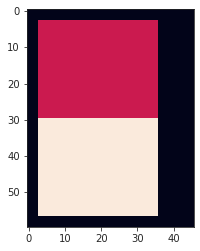

In [11]:
plt.imshow(hemis[..., 30])

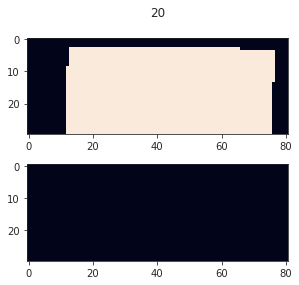

In [12]:
i = 20
fig, axes = create_figure(2, 1)
axes[0].imshow(ml[:30][:, i, :])
axes[1].imshow(ml[30:][:, i, :])
fig.suptitle(i)
plt.show()

In [13]:
for i in range(hemis.shape[1]):
    if ml[30:][:, i, :].sum() or mr[:30][:, i, :].sum():
        fig, axes = create_figure(2, 1)
        axes[0].imshow(ml[:30][:, i, :])
        axes[1].imshow(ml[30:][:, i, :])
        fig.suptitle(i)
        plt.show()

### Mk fig

In [14]:
# snr_filt = snr_all[q_vals > 15]
# snr_filt.shape, snr_all.shape

In [15]:
masks = {
    k: v.numpy().astype(bool)
    for k, v in obj.items()
}
masks = {
    'Brain': single_objectmap.numpy() > 0,
    '~Brain': single_objectmap.numpy() == 0,
    **masks,
}

#### Avg

In [16]:
dlist = []
for k, m in masks.items():
    _m = np.logical_and(m, ml)
    vals = bn.nanmean(snr_all[:, _m], -1)
    dlist.append({
        'label': [k] * len(vals),
        'hemis': ['left'] * len(vals),
        'n_vox': [_m.sum()] * len(vals),
        'tSNR': vals,
    })
    
    _m = np.logical_and(m, mr)
    vals = bn.nanmean(snr_all[:, _m], -1)
    dlist.append({
        'label': [k] * len(vals),
        'hemis': ['right'] * len(vals),
        'n_vox': [_m.sum()] * len(vals),
        'tSNR': vals,
    })
    
df = pd.DataFrame(merge_dicts(dlist))

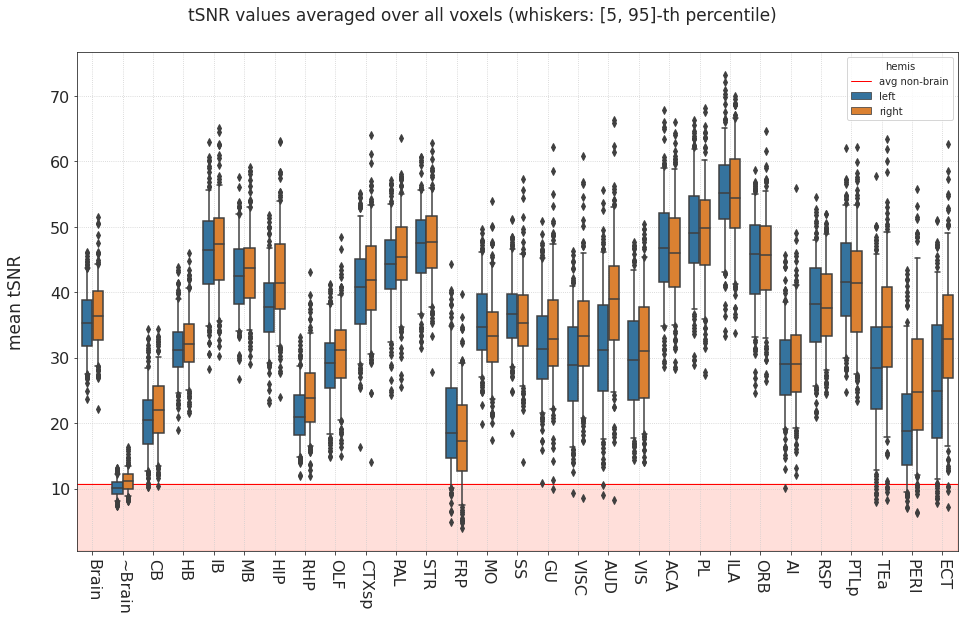

In [17]:
fig, ax = create_figure(1, 1, (13.5, 8.5))

ax.axhline(
    y=df.loc[df['label'] == '~Brain', 'tSNR'].mean(),
    color='r', alpha=1, ls='-', lw=1., zorder=0,
    label='avg non-brain',
)
ax.legend()

sns.boxplot(
    data=df,
    x='label',
    y='tSNR',
    hue='hemis',
    whis=(5, 95),
    saturation=0.7,
    width=0.7,
    ax=ax,
)
ax.set_xlabel('')
ax.set_ylabel(f'mean tSNR\n', fontsize=17)
ax.tick_params('x', rotation=-90)
ax.tick_params('both', labelsize=16)
ax.grid()

ylim_min, ylim_max = ax.get_ylim()
ax.axhspan(
    ymin=ylim_min,
    ymax=df.loc[df['label'] == '~Brain', 'tSNR'].mean(),
    color='tomato', alpha=0.2, ls='-', lw=1.5, zorder=0,
)
ax.set_ylim((ylim_min, ylim_max))
sup = fig.suptitle('tSNR values averaged over all voxels (whiskers: [5, 95]-th percentile)', fontsize=17, y=1.01)
fig.savefig(pjoin(tmp_dir, 'tSNR_avg.pdf'), bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

#### Percent

In [19]:
dlist = []
for kappa in [5, 10, 15, 20, 25, 30, 35]:
    for k, m in masks.items():
        # left hemis
        _m = np.logical_and(m, ml)
        below = bn.nansum(snr_all[:, _m] <= kappa, -1)
        above = bn.nansum(snr_all[:, _m] > kappa, -1)
        percent = above / (above + below) * 100
        dlist.append({
            'kappa': [kappa] * len(percent),
            'label': [k] * len(percent),
            'hemis': ['left'] * len(percent),
            'n_vox': [_m.sum()] * len(percent),
            'percent': percent,
        })
        # right hemis
        _m = np.logical_and(m, mr)
        below = bn.nansum(snr_all[:, _m] <= kappa, -1)
        above = bn.nansum(snr_all[:, _m] > kappa, -1)
        percent = above / (above + below) * 100
        dlist.append({
            'kappa': [kappa] * len(percent),
            'label': [k] * len(percent),
            'hemis': ['right'] * len(percent),
            'n_vox': [_m.sum()] * len(percent),
            'percent': percent,
        })
df = pd.DataFrame(merge_dicts(dlist))

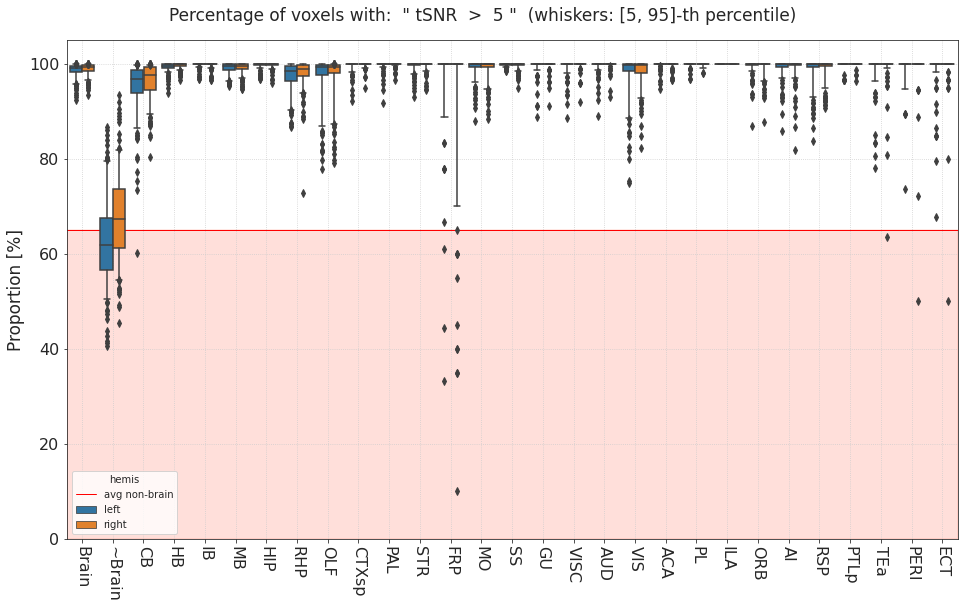

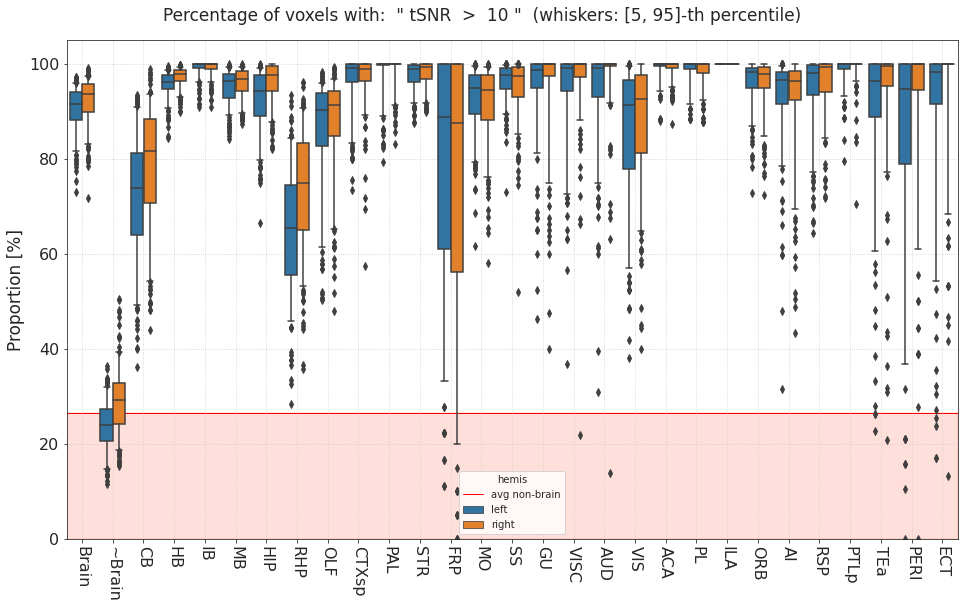

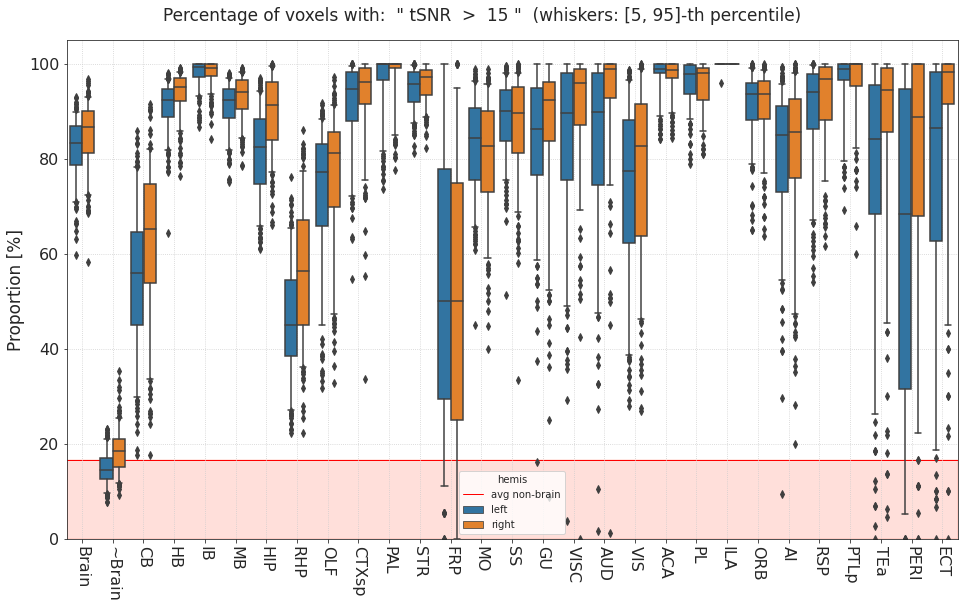

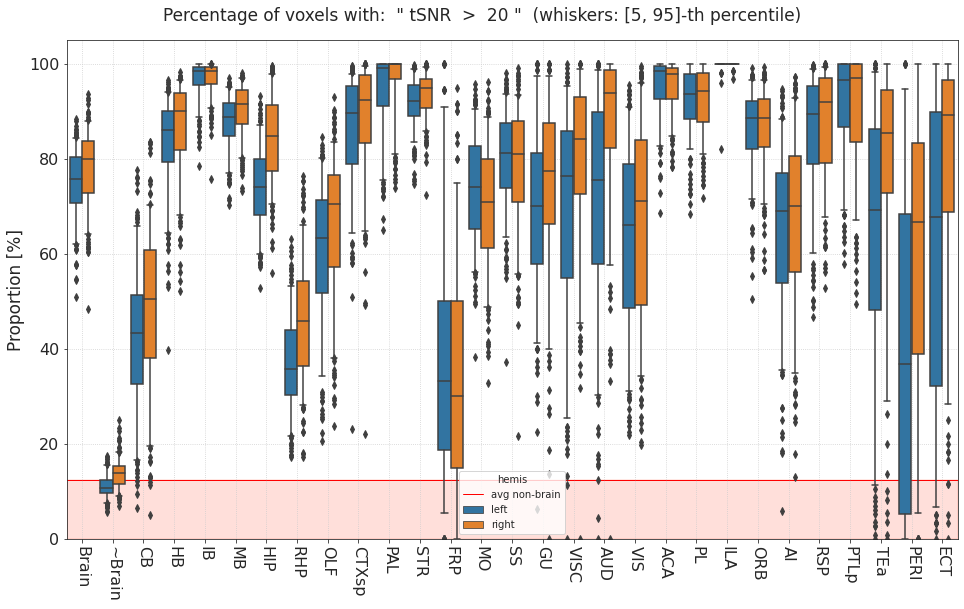

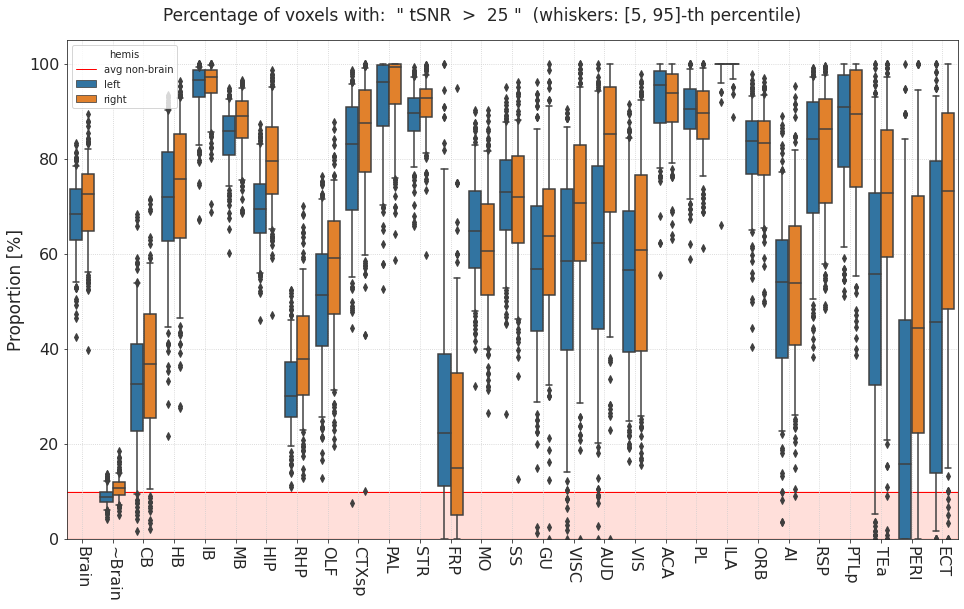

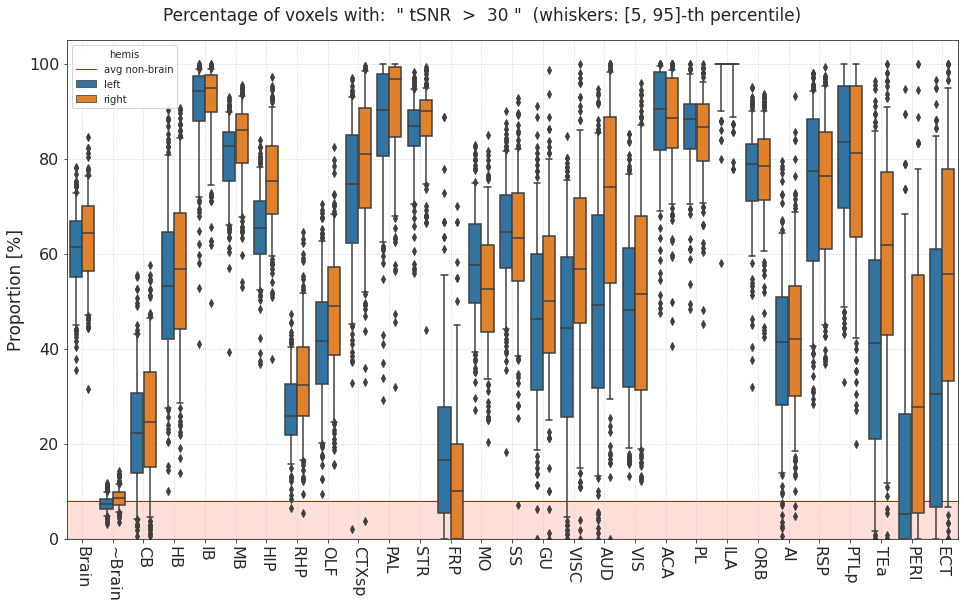

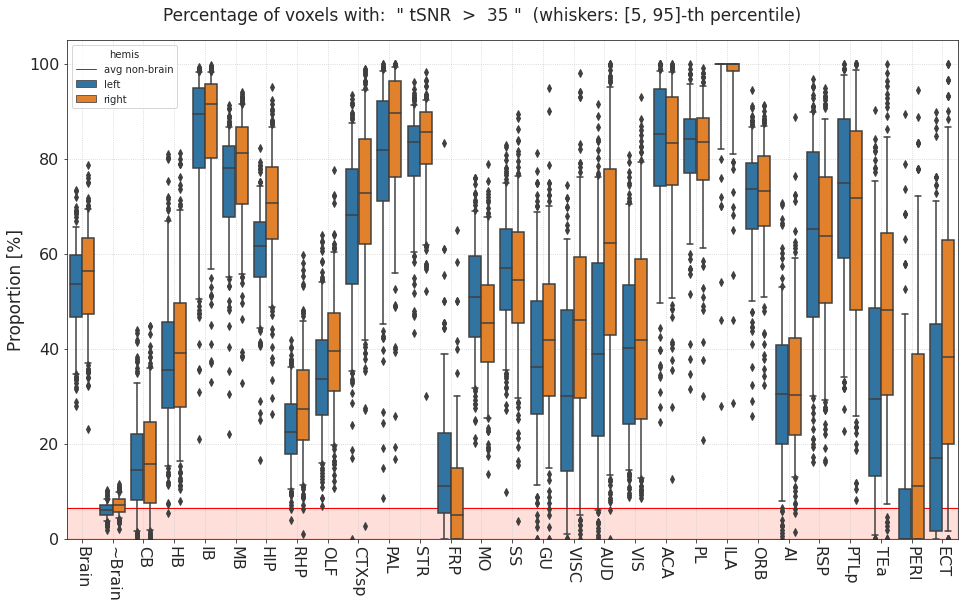

In [20]:
figs, sups = [], []
for kappa in df['kappa'].unique():
    _df = df.loc[df['kappa'] == kappa]
    fig, ax = create_figure(1, 1, (13.5, 8.5))
    
    ax.axhline(
        y=_df.loc[_df['label'] == '~Brain', 'percent'].mean(),
        color='r', alpha=1, ls='-', lw=1., zorder=0,
        label='avg non-brain',
    )
    ax.legend()
    
    sns.boxplot(
        data=_df,
        x='label',
        y='percent',
        hue='hemis',
        whis=(5, 95),
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_ylabel(f"Proportion [%]", fontsize=17)
    ax.set_ylim(0, 105)
    ax.tick_params('x', rotation=-90)
    ax.tick_params('both', labelsize=16)
    ax.grid()

    ylim_min, ylim_max = ax.get_ylim()
    ax.axhspan(
        ymin=ylim_min,
        ymax=_df.loc[_df['label'] == '~Brain', 'percent'].mean(),
        color='tomato', alpha=0.2, ls='-', lw=1.5, zorder=0,
    )
    ax.set_ylim((ylim_min, ylim_max))
    
    sup = f'Percentage of voxels with:  " tSNR  >  {kappa} "  (whiskers: [5, 95]-th percentile)'
    sup = fig.suptitle(sup, fontsize=17, y=0.99)
    figs.append(fig)
    sups.append(sup)

In [21]:
save_fig(figs, sups, pjoin(tmp_dir, 'tSNR_percent.pdf'), multi=True)

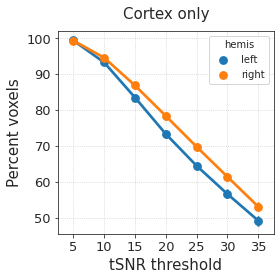

In [22]:
fig, ax = create_figure(1, 1, (4, 4))
cortical = list(masks)[12:]
sns.pointplot(
    data=df.loc[df['label'].isin(cortical)],
    x='kappa',
    y='percent',
    hue='hemis',
    ax=ax,
)
ax.set_xlabel('tSNR threshold', fontsize=15)
ax.set_ylabel('Percent voxels', fontsize=15)
ax.tick_params('both', labelsize=13)
ax.grid()
ax.set_title('Cortex only', fontsize=15, y=1.03)
plt.show()